In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Обработка данных

In [2]:
data = pd.read_csv('SpotifyFeatures.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [3]:
data = data.assign(popularity_class=data.popularity // 26)

## Числовые признаки

Выделим для начала числовые признаки, так как они дополнительной обработки не требуют. Исходя из условия, *popularity* - целевая переменная, поэтому удалю ее из этого списка.

In [4]:
numeric = data.columns[data.dtypes != 'object']
numeric = numeric.drop(['popularity_class', 'popularity'])

Взглянем на тепловую карту корреляций между признаками

<AxesSubplot:>

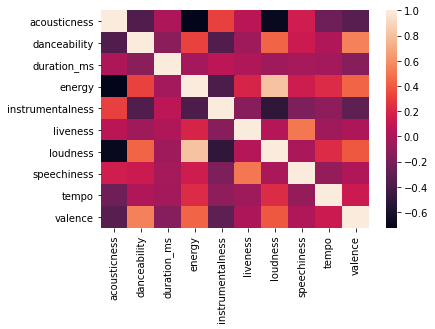

In [5]:
sns.heatmap(data[numeric].corr())

Отдельно построим графики для тех пар переменных, корреляция между которыми по модулю максимальна

In [6]:
sample = data.sample(10000)

<AxesSubplot:xlabel='energy', ylabel='loudness'>

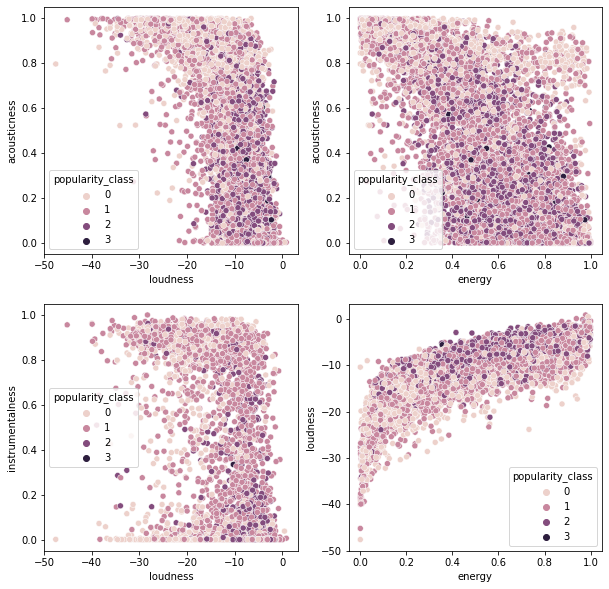

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(data=sample, x=sample['loudness'], y=sample['acousticness'], hue='popularity_class', ax=ax[0][0])
sns.scatterplot(data=sample, x=sample['energy'], y=sample['acousticness'], hue='popularity_class', ax=ax[0][1])
sns.scatterplot(data=sample, x=sample['loudness'], y=sample['instrumentalness'], hue='popularity_class', ax=ax[1][0])
sns.scatterplot(data=sample, x=sample['energy'], y=sample['loudness'], hue='popularity_class', ax=ax[1][1])

Наблюдается некоторый тренд на каждом из графиков, впрочем, вряд ли это повлияет на результат работы линейной регрессии. Поэтому все признаки будем использовать в обучении

Построим гистограммы распределения каждого признака. При этом каждый объект отнесем к одному из 4-х классов, основанных на популярности: от 0 до 25, от 26 до 50, от 51 до 75 и от 76 до 100

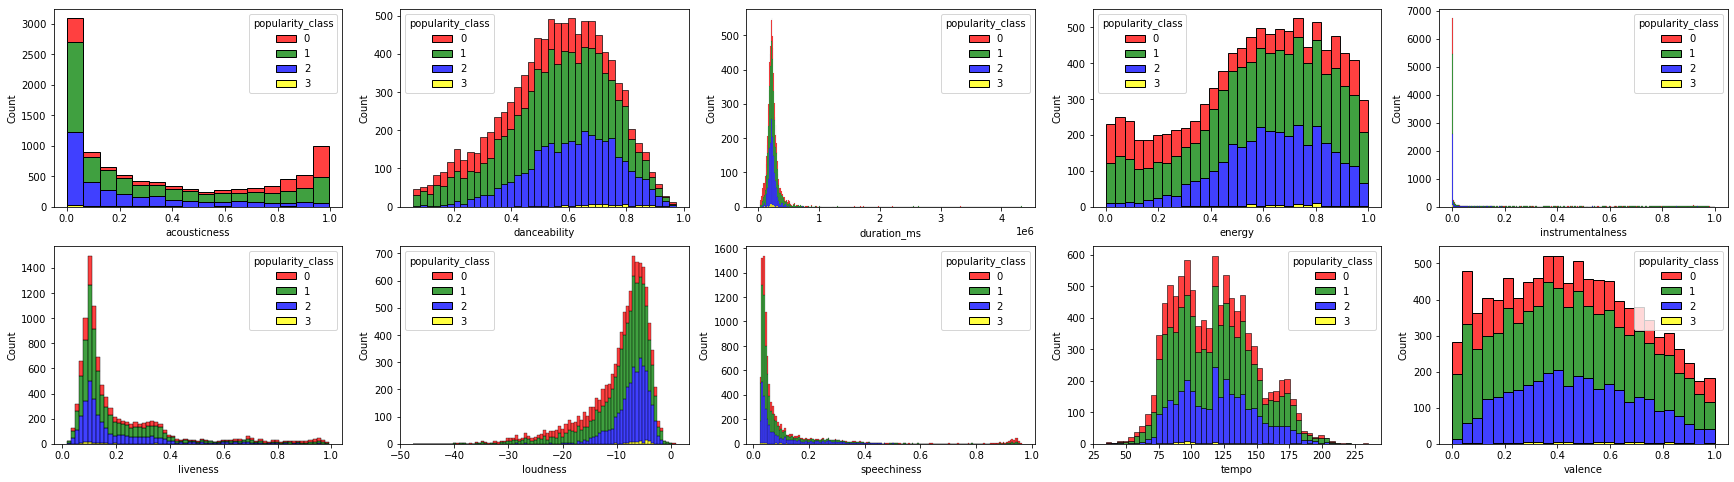

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(30, 8))
i, j = 0, 0
for column in numeric:
    sns.histplot(data=sample, x=sample[f'{column}'], hue='popularity_class', ax=ax[i][j], palette=["red", "green", "blue", "yellow"], multiple="stack")
    j += 1
    
    if j==5 and i==0:
        i = 1
        j = 0

Стоит отметить, что поскольку алгоритм решающего дерева для каждого признака ищет границу, по которой он будет разделять текущий лист, из графиков можно сделать предположение, что признаки *acousticness* и *loudness* будут иметь больший вес относительно остальных. Для *acousticness* это справедливо в силу бимодального распределения признака (неплохо можно отделить например *0-класс* и *3-класс* от остальных. Для *loudness* же почти точно можно установить границу для "хороших" песен, относящихся ко *2 и 3 классам*. Кстати говоря достаточно интересная зависимость популярности трека от его громкости. 

Остальные же признаки должны иметь меньший вес, при их удалении деградация результата не должна быть существенной.

## Категориальные признаки

**genre** - жанр песни - поддается обработке, потенциально высокая связь с популярностью

**artist_name** - имя артиста - слишком много уникальных значений, вряд ли влияет на популярность

**track_name** - название трека - слишком много уникальных значений, вряд ли влияет на популярность

**track_id** - уникальный идентификатор трека - слишком много уникальных значений, никак не связано с популярностью

**key** - аккорд - поддается обработке, связь с популярностью должна отсутствовать

**mode** - тональность - поддается обработке, связь с популярностью должна отсутствовать

**time_signature** - размерность - поддается обработке, связь с популярностью должна отсутствовать

Выберем только жанр. Применим для этого признака OneHot кодирование

In [10]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(data[numeric].join(data.genre))
y = data.popularity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [11]:
cat = set(X.columns) - set(numeric)

# Обучение моделей

Выбрал простую линейную регресиию без регуляризации и лес решающих деревьев. Для линейной регрессии добавил полиномиальные признаки (2-ой степени)

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly_X_train = pd.DataFrame(poly.fit_transform(X_train[numeric]), index=X_train.index)
poly_X_train = poly_X_train.join(X_train[cat])

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

rfr = RandomForestRegressor(random_state=0, n_jobs=-1, verbose=1)
poly_lr = LinearRegression(normalize=True, n_jobs=-1)
lr = LinearRegression(normalize=True, n_jobs=-1)

poly_lr.fit(poly_X_train, y_train)
lr.fit(X_train, y_train)
rfr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.7s finished


RandomForestRegressor(n_jobs=-1, random_state=0, verbose=1)

# Валидация моделей

Пусть результатом, от которого мы будем отталкиваться при валидации моделей, будет значение средней ошибки, когда каждой песне мы ставим в качестве ответа 50 - среднюю возможную оценку.

In [15]:
from sklearn.metrics import mean_absolute_error

baseline = [50] * y_test.size
mean_absolute_error(y_test, baseline)

15.913461951617755

In [16]:
poly_X_test = pd.DataFrame(poly.transform(X_test[numeric]), index=X_test.index)
poly_X_test = poly_X_test.join(X_test[cat])

In [17]:
print(mean_absolute_error(y_test, poly_lr.predict(poly_X_test)))
print(mean_absolute_error(y_test, lr.predict(X_test)))
print(mean_absolute_error(y_test, rfr.predict(X_test)))

7.194587358389416
7.228431010284181


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


7.053317505161305


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


Видим, что случайный лес показал себя лучше линейной регрессии, а добавление полиномиальных признаков не дает существенного прироста точности.

Взглянем на важность каждого признака в модели случайного леса.

<AxesSubplot:>

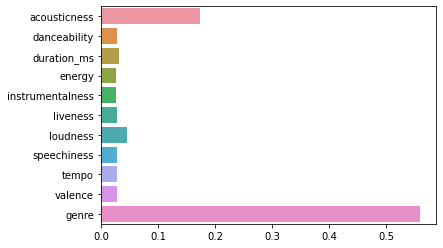

In [18]:
importance = rfr.feature_importances_
importance[10] = sum(importance[10:])
importance = importance[:11]
names = np.array(numeric)
names = np.append(names, 'genre')
sns.barplot(x=importance, y=names)

Предположение о весах подтвердилось. Впрочем, определяющим признаком все же является жанр композиции.

Попробуем обучить лес на меньшем количестве признаков.

In [19]:
X = X.drop(columns=['danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [21]:
rfr_less_features = RandomForestRegressor(random_state=0, n_jobs=-1, verbose=1)
rfr_less_features.fit(X_train, y_train)

mean_absolute_error(y_test, rfr_less_features.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


7.79108838909316

Обучение же на трех главных признаках показало некоторую деградацию точности (+10% к средней абсолютной ошибке), но время обучения сократилось в 2.5 раза